In [1]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
import cvxpy as cp

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

# Introduction

In this project, we picked 5 industries (technology, healthcare, internet, consumer, financial services), and picked 6 stocks from each of them (30 stocks total) and aim to create a portfolio that maximizes overall return while minimizing risk (variance of the returns).

The historical stock data covers the time period from January 2015 to December 2019.

In [2]:
stock_data = pd.read_csv("stockData.csv")
stock_data.head()

,Month,Date,^GSPC,MSFT,CRM,NVDA,ADBE,INTC,TSM,JPM,...,NFLX,T,BIDU,EA,AMZN,TSLA,HD,NKE,SBUX,JD
0,1,1/1/15,1994.989990,35.172421,56.450001,4.610796,70.129997,25.971867,17.671133,42.841724,...,63.114285,13.040134,217.919998,54.115864,17.726500,13.573333,86.433998,42.239990,37.560879,23.869673
1,2,2/1/15,2104.500000,38.175991,69.379997,5.297609,79.099998,26.136938,19.087318,48.588261,...,67.844284,13.948087,203.750000,56.404396,19.007999,13.556000,94.984680,44.469902,40.118443,26.589125
2,3,3/1/15,2067.889893,35.650692,66.809998,5.045598,73.940002,24.756830,18.270283,48.033226,...,59.527142,13.177229,208.399994,58.022144,18.605000,12.584667,94.041061,46.072945,40.785995,28.232327
3,4,4/1/15,2085.510010,42.647549,72.820000,5.351758,76.059998,25.770218,19.017284,50.158184,...,79.500000,13.980376,200.279999,57.302048,21.089001,15.070000,89.008690,45.388725,42.706875,32.249046
4,5,5/1/15,2107.389893,41.086853,72.750000,5.334880,79.089996,27.282393,18.892784,52.502926,...,89.151428,14.206614,197.399994,61.908703,21.461500,16.719999,92.702843,46.688301,44.756927,32.364353


In [3]:
columns = stock_data.columns
columns = columns[2:]
returns = stock_data[columns[1:]][:-1].pct_change(1)[1:]
returns.head()

,MSFT,CRM,NVDA,ADBE,INTC,TSM,JPM,MS,V,RY,...,NFLX,T,BIDU,EA,AMZN,TSLA,HD,NKE,SBUX,JD
1,0.085396,0.229052,0.148958,0.127905,0.006356,0.080141,0.134134,0.061625,0.064337,0.117486,...,0.074943,0.069628,-0.065024,0.042289,0.072293,-0.001277,0.098927,0.052791,0.068091,0.113929
2,-0.066149,-0.037042,-0.047571,-0.065234,-0.052803,-0.042805,-0.011423,-0.002794,-0.033889,-0.036091,...,-0.122592,-0.055266,0.022822,0.028681,-0.021202,-0.071653,-0.009934,0.036048,0.016640,0.061800
3,0.196261,0.089957,0.060679,0.028672,0.040934,0.040886,0.044239,0.045391,0.009785,0.101392,...,0.335525,0.060950,-0.038964,-0.012411,0.133513,0.197489,-0.053512,-0.014851,0.047097,0.142274
4,-0.036595,-0.000961,-0.003154,0.039837,0.058679,-0.006547,0.046747,0.028016,0.039818,-0.033707,...,0.121402,0.016183,-0.014380,0.080393,0.017663,0.109489,0.041503,0.028632,0.048003,0.003576
5,-0.051709,-0.042887,-0.087072,0.024276,-0.110854,-0.064662,0.030101,0.015445,-0.020566,-0.038975,...,0.052687,0.028373,0.008511,0.059592,0.011323,0.069617,-0.002602,0.065357,0.035231,0.012470


### When Maximizing returns and minimizing risk we must use a covariance matrix to get risk values

In [4]:
col_means_returns = returns.mean() #Get average return for each stock in time period
covar_matrix = returns.cov()

## Efficient Portfolio Weight Derivation

Now that we have our returns and covariances, we wish to derive the composition of our portfolio for these stocks which minimizes our risk given that we wish to achieve a certain level of return. Therefore, we have an objective function as follows:

$$ min(\frac{1}{2}\sigma^2) $$

subject to:

$$ \sigma^2 = \sum_{n=i}^{30} \sum_{j=1}^{30} x_i*x_j*\sigma_{ij} $$
$$ E = \sum_{i=1}^{30} x_i * R_i $$
$$ 1 = \sum_{i=1}^{30} x_i $$

where $E$ is our expected return, $\sigma$ is our risk, and $x_i$ is the weight of the $i$ -th stock. We are aiming to derive the best vector of weights $x$ such that we minimize our risk subject to the constraints.

When solving this lagrangian optimization problem we end up with the solution

Denoting $v_{ij} = \frac{1}{\sigma_{ij}}$

$$ x_k = \frac{E * \sum_{i=1}^{30} v_{kj} * (C*R_j - A) + \sum_{i=1}^{30} v_{kj} * (B - AE_j)}{D}$$

Where

$$ A = \sum_{i=1}^{30} \sum_{j=1}^{30} v_{ij} * R_j $$
$$ B = \sum_{i=1}^{30} \sum_{j=1}^{30} v_{ij} * R_i * R_j $$
$$ C = \sum_{i=1}^{30} \sum_{j=1}^{30} v_{ij} $$
$$ D = B*C - A^2 $$


### Suppose that we want to achieve a return of at least 10%, what would be the minimum risk portfolio that theoretically achieves this return

Essentially we set $E = 0.10$ and solve for the weights $x_k$

In [5]:
E = 0.1
ones_vector = np.ones((1, 30))
V = np.linalg.inv(covar_matrix)
A = (ones_vector @ V @ col_means_returns)[0]
B = (col_means_returns @ V @ col_means_returns)
C = (ones_vector @ V @ ones_vector.reshape((30, 1))).flatten()[0]
D = B*C - A**2

In [6]:
C, B, A

(2052.586427469554, 1.0945039275275021, 20.26884297655463)

In [7]:
weights = (1/D) * ((E*V@(C*col_means_returns - A)) + (V @ (B-A*col_means_returns)))
weights

array([ 0.12467244, -0.85511887,  0.64350613, -0.32423767, -0.4586751 ,
        0.61801905,  2.71734408, -1.81286985,  0.55421355, -0.25694959,
       -1.50550333,  0.54675044, -0.34649869,  0.45220391,  0.49321227,
        0.9315138 , -0.9425294 , -0.4024742 , -0.59241166,  0.98955669,
        0.58464636, -0.10716024, -0.20545171, -0.56778796, -0.4365135 ,
        0.08907493, -0.09552292,  0.56537078,  0.75119743, -0.15157715])

As we can see some of these weights are actually negative which may not make sense at first intuitively. But in the financial markets world, we are able to "short" stocks which essentially means selling them at first and then buying them back and returning them later. Essentially, with these stocks, we predict them to go down so their price right now is overvalued.

We can verify these weights by checking that they add up to 1 and that our expected return is the value we targeted.

In [8]:
sum(weights) #verify that the sum of the weights is equal to 1

1.0000000000000009

In [9]:
p_return = weights @ col_means_returns
p_return #verify that the return is equal to 0.1

0.09999999999999996

Since the values seem to make sense, we can then the standard deviation, $\sigma$.

In [10]:
p_risk = (weights @ covar_matrix @ weights)**0.5
p_risk #This is the minimum risk of the optimal portfolio composition of the chosen stocks that achieve a return of 10%

0.09782244485868459

### Based on that standard deviation, given the basket of stocks we chose in the beginning, the best risk we can theoretically achieve is around a variance ($\sigma^2$) of 0.009569 when aiming for a return of 10%. In other words, if an investor wanted a portfolio to achieve a return of at least 10%, they would theoretically need to take on a variance of at least 0.009569 in their returns

Now that we have risk as a function of return and vice-versa, we can create a graph showing the tradeoff between increasing/decreasing risk and its effect on return.

Using the hyperbola method we can come up with the following graph.

In [11]:
risk = np.linspace((1/C)**0.5, 0.022**0.5, 200)
min_risk = 1/C

In [12]:
mean_E_efficient = A/C + (1/C) * (D*C*(risk**2 - min_risk))**0.5
mean_E_inefficient = A/C - (1/C) * (D*C*(risk**2 - min_risk))**0.5

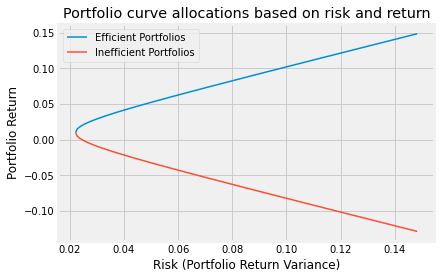

In [13]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(risk, mean_E_efficient)
plt.plot(risk, mean_E_inefficient)
plt.title("Portfolio curve allocations based on risk and return")
plt.xlabel("Risk (Portfolio Return Variance)")
plt.ylabel("Portfolio Return")
plt.legend(['Efficient Portfolios', 'Inefficient Portfolios'])
plt.show()

### As we can see, the blue line gives the most optimal returns of portfolios subject to a certain amount of risk. The orange line gives inefficient portfolios which give minimal returns given corresponding levels of risk.

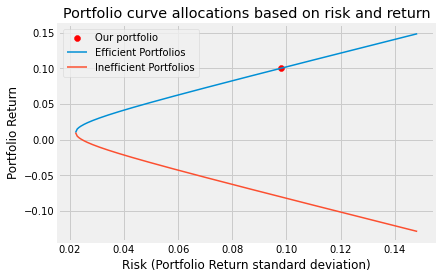

In [14]:
#We can also plot the minimum portfolio composition point that we derived earlier.
plt.scatter(p_risk, p_return, c= "red")
plt.plot(risk, mean_E_efficient)
plt.plot(risk, mean_E_inefficient)
plt.title("Portfolio curve allocations based on risk and return")
plt.xlabel("Risk (Portfolio Return standard deviation)")
plt.ylabel("Portfolio Return")
plt.legend(["Our portfolio", 'Efficient Portfolios', 'Inefficient Portfolios'])
plt.show()

# Calculating Weights Programmatically

Now that we have manually derived the solution to determine the weights for each stock, the problem can be formulated as a quadratic programming problem. We can use the `cvxpy` library to solve for the weights programmatically by providing the objective function and a list of linear constraints.

In [15]:
def solver(cov_matrix, exp_returns):
    # Number of assets
    n_assets = len(exp_returns)

    # Define the variables (weights)
    w = cp.Variable(n_assets)

    # Define the objective function
    risk = cp.quad_form(w, cov_matrix)
    objective = cp.Minimize(0.5 * risk)

    # Define the constraints
    constraints = [
        cp.sum(w) == 1,                    # Sum of weights is 1
        cp.matmul(w, exp_returns) >= 0.1,  # Target expected return of 0.1
    ]

    # Create the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # Retrieve the optimized weights
    optimal_weights = w.value
    
    return optimal_weights

In [16]:
# Covariance matrix and expected returns converted to numpy
cov_matrix = covar_matrix.to_numpy()
exp_returns = col_means_returns.to_numpy()

# Use solver to determine weights
solver_weights = solver(cov_matrix, exp_returns)

# Compare with manually calculated weights
print('Manually calculated weights:')
print(weights)
print('Programmatically calculated weights:')
print(solver_weights)

cos_sim = np.dot(weights, solver_weights)/(np.linalg.norm(weights)*np.linalg.norm(solver_weights))
print('Cosine similarity: ', cos_sim)

Manually calculated weights:
[ 0.12467244 -0.85511887  0.64350613 -0.32423767 -0.4586751   0.61801905
  2.71734408 -1.81286985  0.55421355 -0.25694959 -1.50550333  0.54675044
 -0.34649869  0.45220391  0.49321227  0.9315138  -0.9425294  -0.4024742
 -0.59241166  0.98955669  0.58464636 -0.10716024 -0.20545171 -0.56778796
 -0.4365135   0.08907493 -0.09552292  0.56537078  0.75119743 -0.15157715]
Programmatically calculated weights:
[ 0.12467244 -0.85511887  0.64350613 -0.32423767 -0.4586751   0.61801905
  2.71734408 -1.81286985  0.55421355 -0.25694959 -1.50550333  0.54675044
 -0.34649869  0.45220391  0.49321227  0.9315138  -0.9425294  -0.4024742
 -0.59241166  0.98955669  0.58464636 -0.10716023 -0.20545171 -0.56778796
 -0.4365135   0.08907493 -0.09552292  0.56537078  0.75119743 -0.15157715]
Cosine similarity:  0.9999999999999998


# Forecasting Stock Data

Since the portfolio weights can be calculated exactly using quadratic programming, we turn to ML as a way to predict the values of the stocks. The goal is to determine if the portfolio we create based on predicted data is similar to the portfolio that was created based on the recorded historical data.

For this we use a library called `skforecast` which is dedicated to predicting time series data using the `sklearn` API for different regression models. Here we compare four different regression models to predict a years worth of stock values.

The models we chose are:

* Ridge Regression (linear)
* KNN Regression
* Random Forest Regression
* Gradient Boosting Regression

For each model, we use a grid search to find the best parameters for each stock individually, resulting in 30 different optimized models for each regression technique. Since each stock has varying ranges of values, in order to compare the models we use normalized root-mean-square error (NRMSE), where the MSE is converted to RMSE and divided by the standard deviation of the given data to determine a normalized loss value for each of the 30 models of a regression technique, and then take the average NRMSE value to be compared between the techniques.

$$NRMSE = \frac{\sqrt{MSE}}{\sigma}$$

First, we modify the data by indexing on the date and dropping unnecessary columns. We also set the frequency to be monthly, which will be used by `skforecast`.

In [17]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'], infer_datetime_format = True)
stock_data = stock_data.set_index('Date')
stock_data = stock_data.asfreq('MS')
stock_data = stock_data.sort_index()
stock_data = stock_data.drop("Month", axis = 1)
stock_data.head()

,^GSPC,MSFT,CRM,NVDA,ADBE,INTC,TSM,JPM,MS,V,...,NFLX,T,BIDU,EA,AMZN,TSLA,HD,NKE,SBUX,JD
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1994.989990,35.172421,56.450001,4.610796,70.129997,25.971867,17.671133,42.841724,27.535347,60.231667,...,63.114285,13.040134,217.919998,54.115864,17.726500,13.573333,86.433998,42.239990,37.560879,23.869673
2015-02-01,2104.500000,38.175991,69.379997,5.297609,79.099998,26.136938,19.087318,48.588261,29.232225,64.106773,...,67.844284,13.948087,203.750000,56.404396,19.007999,13.556000,94.984680,44.469902,40.118443,26.589125
2015-03-01,2067.889893,35.650692,66.809998,5.045598,73.940002,24.756830,18.270283,48.033226,29.150547,61.934250,...,59.527142,13.177229,208.399994,58.022144,18.605000,12.584667,94.041061,46.072945,40.785995,28.232327
2015-04-01,2085.510010,42.647549,72.820000,5.351758,76.059998,25.770218,19.017284,50.158184,30.473707,62.540260,...,79.500000,13.980376,200.279999,57.302048,21.089001,15.070000,89.008690,45.388725,42.706875,32.249046
2015-05-01,2107.389893,41.086853,72.750000,5.334880,79.089996,27.282393,18.892784,52.502926,31.327469,65.030502,...,89.151428,14.206614,197.399994,61.908703,21.461500,16.719999,92.702843,46.688301,44.756927,32.364353


Because we changed the frequency information, we verify that `pandas` did not modify our data and introduce any null values.

In [18]:
print(f'Number of rows with missing values: {stock_data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


Next we split our data into a training set and a test set. Since we have 5 years worth of data (Jan, 2015 to Dec, 2019), we will use the last 12 months as test data.

In [19]:
steps = 12 #last ~20% set aside as test data
data_train = stock_data[:-steps]
data_test  = stock_data[-steps:]

We can then verify that our split was successful and visualize some of the stock data.

We have randomly chosen 5 stocks to visualize: MSFT (Microsoft), PFE (Pfizer), HD (Home Depot), NFLX (Netflix), and GOOGL (Google)

Train dates : 2015-01-01 00:00:00 --- 2018-12-01 00:00:00  (n=48)
Test dates  : 2019-01-01 00:00:00 --- 2019-12-01 00:00:00  (n=12)


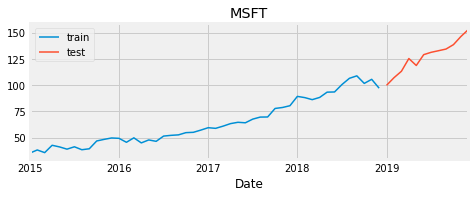

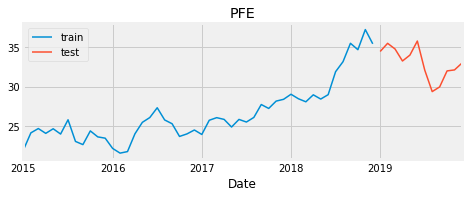

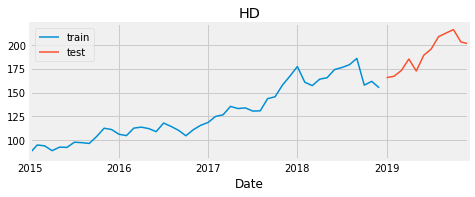

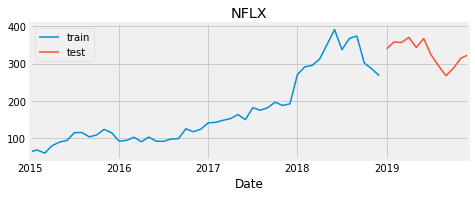

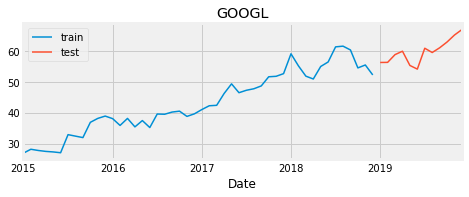

In [20]:
choices = ["MSFT", "PFE", "HD", "NFLX", "GOOGL"]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

for choice in choices:
    fig, ax = plt.subplots(figsize=(7, 2.5))
    data_train[choice].plot(ax=ax, label='train')
    data_test[choice].plot(ax=ax, label='test')
    plt.title(choice)
    ax.legend()

## Ridge Regression

In [21]:
# Hyperparameter Grid search - Ridge
# ==============================================================================

# Lags used as predictors
lags_grid = [3, 6, 12, 18]

# Regressor's hyperparameters
param_grid = {'alpha': [0.01, 0.1, 1, 2]}
lr_forecasters = {}

avg_error = 0

for stock_choice in stock_data.columns.values:
    forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 12 # This value will be replaced in the grid search
             )
    
    results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data_train[stock_choice],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = steps,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)*0.5),
                            fixed_train_size   = False,
                            return_best        = True,
                            verbose            = False
                   )
    lr_forecasters[stock_choice] = forecaster

    # calculate NRMSE
    error_mse = mean_squared_error(y_true = data_test[stock_choice], y_pred = forecaster.predict(steps=steps))
    error_nrmse = np.sqrt(error_mse) / data_test[stock_choice].std()

    # sum for average error
    avg_error += error_nrmse

# Calculate average error
avg_error = avg_error / 30

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 69955.56853567575

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 70.69120443725193

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 248.3830724121915

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 2}
  Backtesting metric: 1967.5793553273545

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 1566.8799272881822

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'alpha': 2}
  Backtesting metric: 22.494668604952228

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 2}
  Backtesting metric: 48.93674104037476

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 163.3265711459549

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 89.48547068446696

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 325.30043188277614

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 2}
  Backtesting metric: 31.090688798677338

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 1034.414970060401

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 45.93678584338975

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 2}
  Backtesting metric: 235.4709365151425

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 2.87468214166543

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'alpha': 2}
  Backtesting metric: 311.1960792956819

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 112.11451230717273

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 26.50064328790324

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 23.87361773507473

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 43.952514760344705

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 1828.0654944555117

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 2}
  Backtesting metric: 5504.576205905384

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'alpha': 2}
  Backtesting metric: 1.7800014192415412

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 1422.902401316902

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 680.8367017797458

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 2}
  Backtesting metric: 121.75970510938055

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 22.789920570313402

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 1976.795224103328

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 154.90064590645525

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'alpha': 2}
  Backtesting metric: 13.680934370064897

Number of models compared: 16.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'alpha': 0.01}
  Backtesting metric: 85.91198477040074



Avg error: 4.835284284446986


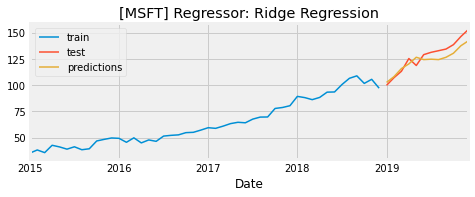

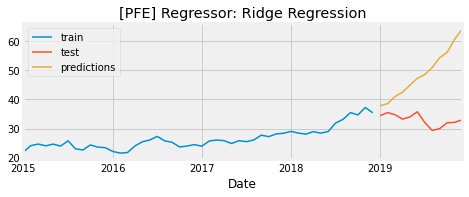

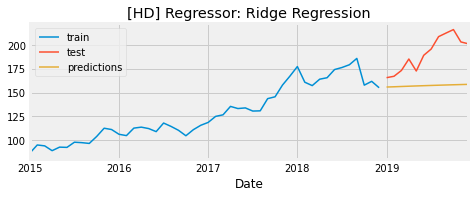

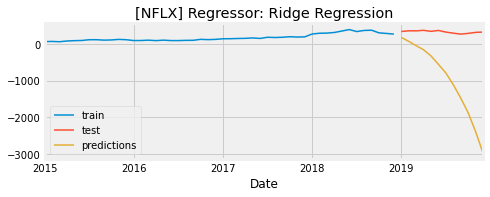

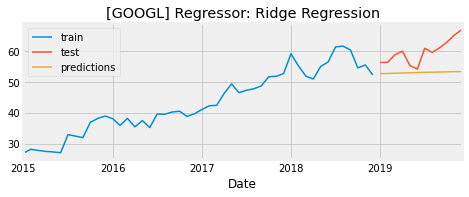

In [22]:
print("Avg error:", avg_error)

for stock_choice in choices:
    predictions = lr_forecasters[stock_choice].predict(steps=steps)
    # Plot
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(7, 2.5))
    data_train[stock_choice].plot(ax=ax, label='train')
    data_test[stock_choice].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    plt.title("[" + stock_choice + "] " + "Regressor: Ridge Regression")
    ax.legend()

## KNN Regression

In [23]:
# Hyperparameter Grid search - KNN
# ==============================================================================

# Lags used as predictors
lags_grid = [3, 6, 12, 18]

# Regressor's hyperparameters
param_grid = {'n_neighbors': [1, 3, 5],
              'weights': ['uniform', 'distance']}

knn_forecasters = {}
avg_error = 0

for stock_choice in stock_data.columns.values:
    forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(),
                lags      = 12 # This value will be replaced in the grid search
             )
    
    results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data_train[stock_choice],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = steps,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)*0.5),
                            fixed_train_size   = False,
                            return_best        = True,
                            verbose            = False
                   )
    knn_forecasters[stock_choice] = forecaster
    error_mse = mean_squared_error(y_true = data_test[stock_choice], y_pred = forecaster.predict(steps=steps))
    error_nrmse = np.sqrt(error_mse) / data_test[stock_choice].std()
    avg_error += error_nrmse
    
avg_error = avg_error / 30

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 40382.009905491694

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 1, 'weights': 'distance'}
  Backtesting metric: 244.13139468442935

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
  Backtesting metric: 686.9366901913096

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 197.7385537029535

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
  Backtesting metric: 3105.181213808641

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 16.962661175295455

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
  Backtesting metric: 24.716856753438652

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 59.081458241437076

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 1, 'weights': 'distance'}
  Backtesting metric: 52.03282632397182

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 447.02116454669334

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_neighbors': 1, 'weights': 'distance'}
  Backtesting metric: 34.81944773040169

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
  Backtesting metric: 1193.8390422372638

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 6.9662183638519535

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
  Backtesting metric: 135.8355772714218

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 13.192473414733913

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
  Backtesting metric: 279.6838974499913

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 1, 'weights': 'distance'}
  Backtesting metric: 168.4784703334495

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 20.043831426250787

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 13.171322128863622

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 47.52623491308634

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 5, 'weights': 'distance'}
  Backtesting metric: 927.2991822863772

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 3, 'weights': 'uniform'}
  Backtesting metric: 10324.505393936703

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 3, 'weights': 'distance'}
  Backtesting metric: 1.400690333647587

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
  Backtesting metric: 1353.1279673710587

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 5, 'weights': 'uniform'}
  Backtesting metric: 542.0584522650687

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 410.44108192354634

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 23.06227293629708

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
  Backtesting metric: 398.6249590649864

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'n_neighbors': 1, 'weights': 'distance'}
  Backtesting metric: 168.9387573521353

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'n_neighbors': 3, 'weights': 'distance'}
  Backtesting metric: 11.011679037360656

Number of models compared: 24.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'n_neighbors': 5, 'weights': 'distance'}
  Backtesting metric: 86.0705496287237



Avg error: 1.880732657236123


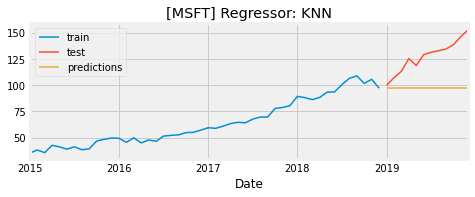

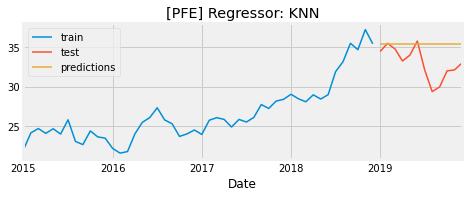

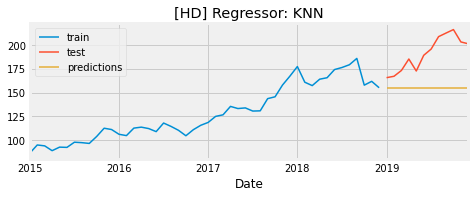

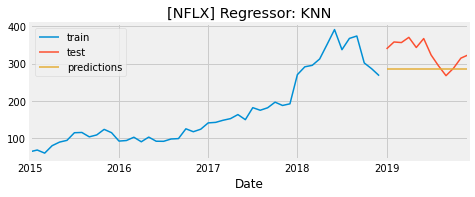

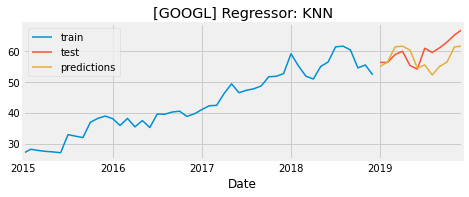

In [24]:
print("Avg error:", avg_error)

for stock_choice in choices:
    predictions = knn_forecasters[stock_choice].predict(steps=steps)
    # Plot
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(7, 2.5))
    data_train[stock_choice].plot(ax=ax, label='train')
    data_test[stock_choice].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    plt.title("[" + stock_choice + "] " + "Regressor: KNN")
    ax.legend();

## Random Forest Regression

In [25]:
# Hyperparameter Grid search - Random Forest
# ==============================================================================
steps = 12

# Lags used as predictors
lags_grid = [3, 6, 12, 18]

# Regressor's hyperparameters
param_grid = {'n_estimators': [1, 10, 50],
              'max_depth': [3, 7, 12]}

rf_forecasters = {}
avg_error = 0

for stock_choice in stock_data.columns.values:
    forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(),
                lags      = 12 # This value will be replaced in the grid search
             )
    
    results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data_train[stock_choice],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = steps,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)*0.5),
                            fixed_train_size   = False,
                            return_best        = True,
                            verbose            = False
                   )
    rf_forecasters[stock_choice] = forecaster
    error_mse = mean_squared_error(y_true = data_test[stock_choice], y_pred = forecaster.predict(steps=steps))
    error_nrmse = np.sqrt(error_mse) / data_test[stock_choice].std()
    avg_error += error_nrmse
    
avg_error = avg_error / 30

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 40382.009905491694

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 244.1313946844294

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 690.1289581666928

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 174.2518736413555

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 2739.446291132526

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 15.271615693786956

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 20.36024189279978

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 66.02990803996407

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 21.131045516250673

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 414.89026335412024

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 31.216951317839033

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 469.78171409786074

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 7.919476491576789

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 84.14109414710768

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 13.342084806495118

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 259.08908491832324

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 153.86714002827978

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 22.2111789901022

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 11.330463839035952

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 46.05253656029483

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 710.2436205850496

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 9698.755244812566

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 1.6326791229017406

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 12, 'n_estimators': 10}
  Backtesting metric: 1397.39638830884

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 471.58982913184917

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 3, 'n_estimators': 1}
  Backtesting metric: 374.10362338717215

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 14.4979012975567

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 391.02886272344307

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 12, 'n_estimators': 1}
  Backtesting metric: 106.29895452010904

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 7, 'n_estimators': 1}
  Backtesting metric: 10.409483535530294

Number of models compared: 36.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

params grid:   0%|          | 0/9 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'max_depth': 3, 'n_estimators': 10}
  Backtesting metric: 103.64134517184617



Avg error: 1.9674592846621555


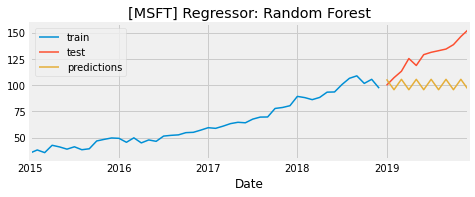

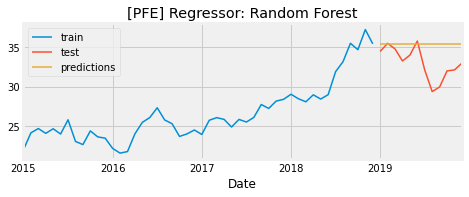

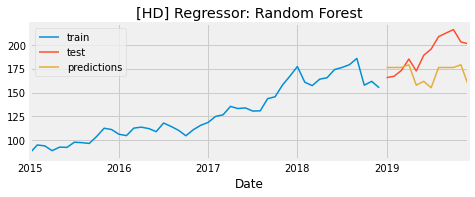

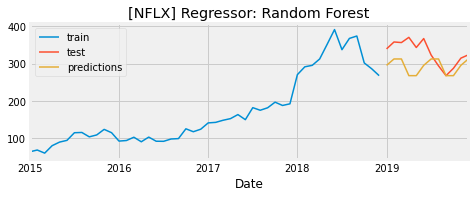

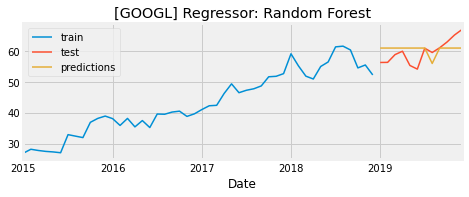

In [26]:
print("Avg error:", avg_error)

for stock_choice in choices:
    predictions = rf_forecasters[stock_choice].predict(steps=steps)
    # Plot
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(7, 2.5))
    data_train[stock_choice].plot(ax=ax, label='train')
    data_test[stock_choice].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    plt.title("[" + stock_choice + "] " + "Regressor: Random Forest")
    ax.legend();

## Gradient Boosting Regression

In [27]:
# Hyperparameter Grid search - Gradient Boosting
# ==============================================================================
steps = 12

# Lags used as predictors
lags_grid = [3, 6, 12, 18]

# Regressor's hyperparameters
param_grid = {'n_estimators': [1, 10, 50, 200],
             'learning_rate': [0.1, 0.01, 0.001],
             'max_depth': [3, 6, 9],
             'loss': ['squared_error']}

gb_forecasters = {}
avg_error = 0

for stock_choice in stock_data.columns.values:
    forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(),
                lags      = 12 # This value will be replaced in the grid search
             )
    
    results_grid = grid_search_forecaster(
                            forecaster         = forecaster,
                            y                  = data_train[stock_choice],
                            param_grid         = param_grid,
                            lags_grid          = lags_grid,
                            steps              = steps,
                            refit              = True,
                            metric             = 'mean_squared_error',
                            initial_train_size = int(len(data_train)*0.5),
                            fixed_train_size   = False,
                            return_best        = True,
                            verbose            = False
                   )
    gb_forecasters[stock_choice] = forecaster
    error_mse = mean_squared_error(y_true = data_test[stock_choice], y_pred = forecaster.predict(steps=steps))
    error_nrmse = np.sqrt(error_mse) / data_test[stock_choice].std()
    avg_error += error_nrmse
    
avg_error = avg_error / 30

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 40382.00998287651

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 244.13139564527367

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 664.7947419897514

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 191.11255382698542

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 2912.6127508967998

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 50}
  Backtesting metric: 17.114654864717195

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 50}
  Backtesting metric: 25.551412565284494

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 68.37059378527721

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 21.921869807347452

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 200}
  Backtesting metric: 404.3755185455493

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 37.1141964581725

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 200}
  Backtesting metric: 462.8445665146105

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 6.966218445156799

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 10}
  Backtesting metric: 133.4197265288098

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 200}
  Backtesting metric: 12.401063596636922

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 271.45975259275355

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 200}
  Backtesting metric: 164.85424230547184

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 50}
  Backtesting metric: 23.61763288960945

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 9.917337455513232

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 44.15473076242861

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 200}
  Backtesting metric: 895.4370347388918

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 10256.256019475888

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5 6] 
  Parameters: {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 1.5863986695203611

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 50}
  Backtesting metric: 1310.43622162316

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 200}
  Backtesting metric: 528.7686305417996

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 6, 'n_estimators': 200}
  Backtesting metric: 404.0689221445655

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 200}
  Backtesting metric: 14.08052314859637

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'n_estimators': 50}
  Backtesting metric: 447.5555856530644

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 107.92756046952134

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 200}
  Backtesting metric: 12.082574524230402

Number of models compared: 144.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

params grid:   0%|          | 0/36 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'learning_rate': 0.01, 'loss': 'squared_error', 'max_depth': 9, 'n_estimators': 50}
  Backtesting metric: 71.61540024129236



Avg error: 1.924838648145856


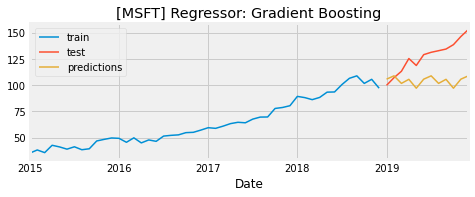

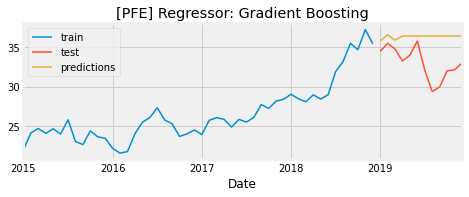

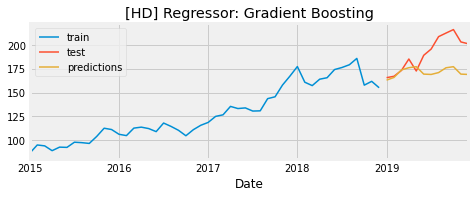

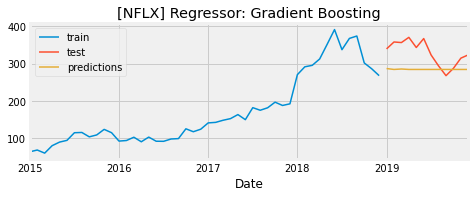

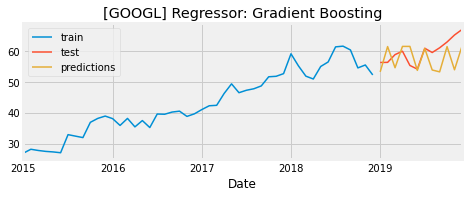

In [28]:
print("Avg error:", avg_error)

for stock_choice in choices:
    predictions = gb_forecasters[stock_choice].predict(steps=steps)
    # Plot
    # ==============================================================================
    fig, ax = plt.subplots(figsize=(7, 2.5))
    data_train[stock_choice].plot(ax=ax, label='train')
    data_test[stock_choice].plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    plt.title("[" + stock_choice + "] " + "Regressor: Gradient Boosting")
    ax.legend();

# Generating New Portfolio Weights

From the results we saw that the KNN regressor provided the smallest average error among the regressors. To determine if it is able to predict accurately enough that we can create portfolios based on it, we will replace the last year of stock data with the KNN predictions and generate new portfolio weights to be compared to the weights based on the given values.

First we generate the predictions for the last year, then we combine it with the rest of the data.

In [29]:
knn_forecasters.values()
knn_stock_data = pd.DataFrame()

for stock, fc in knn_forecasters.items():
    predictions = fc.predict(steps = steps)
    knn_stock_data = pd.concat([knn_stock_data, predictions.rename(stock)], axis = 1)

knn_stock_data = pd.concat([data_train, knn_stock_data])
knn_stock_data.head()

,^GSPC,MSFT,CRM,NVDA,ADBE,INTC,TSM,JPM,MS,V,...,NFLX,T,BIDU,EA,AMZN,TSLA,HD,NKE,SBUX,JD
2015-01-01,1994.989990,35.172421,56.450001,4.610796,70.129997,25.971867,17.671133,42.841724,27.535347,60.231667,...,63.114285,13.040134,217.919998,54.115864,17.726500,13.573333,86.433998,42.239990,37.560879,23.869673
2015-02-01,2104.500000,38.175991,69.379997,5.297609,79.099998,26.136938,19.087318,48.588261,29.232225,64.106773,...,67.844284,13.948087,203.750000,56.404396,19.007999,13.556000,94.984680,44.469902,40.118443,26.589125
2015-03-01,2067.889893,35.650692,66.809998,5.045598,73.940002,24.756830,18.270283,48.033226,29.150547,61.934250,...,59.527142,13.177229,208.399994,58.022144,18.605000,12.584667,94.041061,46.072945,40.785995,28.232327
2015-04-01,2085.510010,42.647549,72.820000,5.351758,76.059998,25.770218,19.017284,50.158184,30.473707,62.540260,...,79.500000,13.980376,200.279999,57.302048,21.089001,15.070000,89.008690,45.388725,42.706875,32.249046
2015-05-01,2107.389893,41.086853,72.750000,5.334880,79.089996,27.282393,18.892784,52.502926,31.327469,65.030502,...,89.151428,14.206614,197.399994,61.908703,21.461500,16.719999,92.702843,46.688301,44.756927,32.364353


We then calculate the returns based on this new data.

In [30]:
columns = knn_stock_data.columns[1:]
returns = knn_stock_data[columns].pct_change(1)[1:]
returns.head()

,MSFT,CRM,NVDA,ADBE,INTC,TSM,JPM,MS,V,RY,...,NFLX,T,BIDU,EA,AMZN,TSLA,HD,NKE,SBUX,JD
2015-02-01,0.085396,0.229052,0.148958,0.127905,0.006356,0.080141,0.134134,0.061625,0.064337,0.117486,...,0.074943,0.069628,-0.065024,0.042289,0.072293,-0.001277,0.098927,0.052791,0.068091,0.113929
2015-03-01,-0.066149,-0.037042,-0.047571,-0.065234,-0.052803,-0.042805,-0.011423,-0.002794,-0.033889,-0.036091,...,-0.122592,-0.055266,0.022822,0.028681,-0.021202,-0.071653,-0.009934,0.036048,0.016640,0.061800
2015-04-01,0.196261,0.089957,0.060679,0.028672,0.040934,0.040886,0.044239,0.045391,0.009785,0.101392,...,0.335525,0.060950,-0.038964,-0.012411,0.133513,0.197489,-0.053512,-0.014851,0.047097,0.142274
2015-05-01,-0.036595,-0.000961,-0.003154,0.039837,0.058679,-0.006547,0.046747,0.028016,0.039818,-0.033707,...,0.121402,0.016183,-0.014380,0.080393,0.017663,0.109489,0.041503,0.028632,0.048003,0.003576
2015-06-01,-0.051709,-0.042887,-0.087072,0.024276,-0.110854,-0.064662,0.030101,0.015445,-0.020566,-0.038975,...,0.052687,0.028373,0.008511,0.059592,0.011323,0.069617,-0.002602,0.065357,0.035231,0.012470


Finally, we can generate new weights for the portfolio based on our quadratic programming solution to the optimization problem and compare them to the old weights.

In [31]:
col_means_returns = returns.mean() #Get average return for each stock in time period
covar_matrix = returns.cov()

# Covariance matrix and expected returns
cov_matrix = covar_matrix.to_numpy()
exp_returns = col_means_returns.to_numpy()
solver_weights = solver(cov_matrix, exp_returns)

print('Original Weights:')
print(weights)
print('KNN Weights:')
print(solver_weights)

cos_sim = np.dot(weights, solver_weights)/(np.linalg.norm(weights)*np.linalg.norm(solver_weights))
print("Cosine Similarity: ", cos_sim)

Original Weights:
[ 0.12467244 -0.85511887  0.64350613 -0.32423767 -0.4586751   0.61801905
  2.71734408 -1.81286985  0.55421355 -0.25694959 -1.50550333  0.54675044
 -0.34649869  0.45220391  0.49321227  0.9315138  -0.9425294  -0.4024742
 -0.59241166  0.98955669  0.58464636 -0.10716024 -0.20545171 -0.56778796
 -0.4365135   0.08907493 -0.09552292  0.56537078  0.75119743 -0.15157715]
KNN Weights:
[ 0.12662467 -1.8737446   0.90824609  0.37044849 -0.34631005 -0.15021369
  1.60425888 -1.03171356 -0.04472317  0.37954294 -1.32698402 -0.62002175
  0.18679296  2.43906447  0.27751127  0.425644   -1.13023204 -0.75054064
 -0.61422186  0.88971612  0.86598584 -0.68990862 -0.39414791 -1.18655389
  0.06112136 -0.00334822  0.92155956  0.07751908  0.97470479  0.65392349]
Cosine Similarity:  0.6984024948750844


We can see that the new weights have a cosine similarity of only about 70%.

Next we compare the risk between the portfolio created from the given data and the portfolio using the new data.

In [34]:
p_risk = (solver_weights @ covar_matrix @ solver_weights)**0.5
print("Original Risk: 0.09782244485868459, Solver Risk: ", p_risk)

Original Risk: 0.09782244485868459, Solver Risk:  0.09510258055473123


Although the 2 different sets of portfolio weights are only about 70% consistent, the calculated risk for each of them is actually quite similar. 

Overall, none of the models performed particularly well at predicting the stock data. This is to be expected because they likely follow a very complicated function and can be affected by random factors such as policy changes within the companies. To truly capture the complexity of the market we would likely need a much more complicated model such as a complex neural network.